<a href="https://colab.research.google.com/github/bptripp/ai-course/blob/main/digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Categorizing Images with Convolutional Networks

# Convolution
A "convolutional network" is a neural network in which some of the layers use convolution, a mathematical operation that has many uses in engineering. Convolution combines an input with a "kernel". The input can be a signal (e.g. as an ECG wave) or an image (e.g. an x-ray) or a volume (e.g. an MRI). The kernel has the same number of dimensions as the input, but it is usually much smaller. Let's plot a small signal and its convolution with a kernel. 

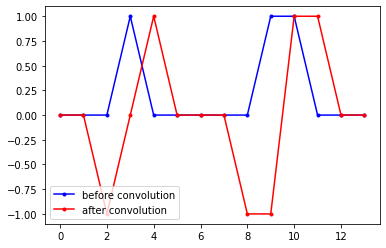

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

signal = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])
kernel = np.array([-1, 0, 1])
combination = np.convolve(signal, kernel, mode='same')

plt.plot(signal, 'b.-')
plt.plot(combination, 'r.-')
plt.legend(('before convolution', 'after convolution'));

Now let's plot process an image with convolution. We will load an image from a file and convolve it with a kernel that makes it blurry. 

--2022-02-27 16:02:33--  http://bptripp.com/xray-example.jpg
Resolving bptripp.com (bptripp.com)... 64.90.50.171
Connecting to bptripp.com (bptripp.com)|64.90.50.171|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 906335 (885K) [image/jpeg]
Saving to: ‘xray-example.jpg’

xray-example.jpg    100%[===================>] 885.09K   868KB/s    in 1.0s    

2022-02-27 16:02:34 (868 KB/s) - ‘xray-example.jpg’ saved [906335/906335]



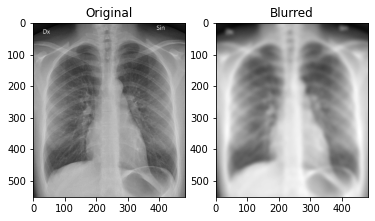

In [ ]:
import imageio
from scipy.signal import gaussian
from scipy.ndimage import convolve

!wget bptripp.com/xray-example.jpg # retrieve an image from the internet
image = imageio.imread('xray-example.jpg') 
image = image[::4,::4,0] # use every 4th pixel to reduce the image size

g = gaussian(21, 5)
kernel = np.outer(g, g) / (2*np.pi*5**2)

blurry = convolve(image, kernel)
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(blurry, cmap='gray');
plt.title('Blurred');


Convolving with different kernels can emphasize different shapes in the image. To illustrate, we now convolve with two more kernels, one that emphasizes vertical lines (like the spinal cord) and another that emphasizes diagonal lines (like the ribs on one side).

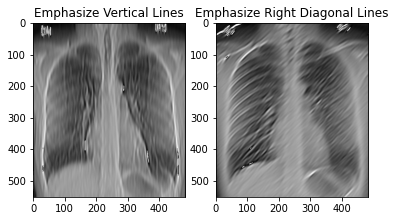

In [ ]:
from skimage.filters import gabor_kernel

vertical_kernel = 20*gabor_kernel(.1, 0, sigma_x=4, sigma_y=8).real
diagonal_kernel = 20*gabor_kernel(.1, np.pi/4, sigma_x=4, sigma_y=8).real

vertical_emphasis = convolve(image, vertical_kernel)
diagonal_emphasis = convolve(image, diagonal_kernel)

plt.subplot(1,2,1)
plt.imshow(vertical_emphasis, cmap='gray')
plt.title('Emphasize Vertical Lines')
plt.subplot(1,2,2)
plt.imshow(diagonal_emphasis, cmap='gray')
plt.title('Emphasize Right Diagonal Lines');

We see that convolving an image with different kernels emphasizes different shapes. In a convolutional network, the image is convolved with hundreds of different kernels that emphasize a wide range of shapes. This produces many different processed images, likes the ones above. Those processed images are passed through more kernels to pick out more complex shapes, and so on. 

The numbers and sizes of kernels are specified by the programmer, but the kernel shapes are learned. They are random at first, and during learning they are gradually adjusted in such a way that the network performs its task more accurately. Calculus is used (specifically, the chain rule for derivatives) to determine how each kernel can be changed to improve performance of the network. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Now back to AI. Below is a class definition for a kind of small convolutional network, which we will call DigitNetwork. This network's job will be to classify images of handwritten digits as being 0, 1, 2, 3, 4, 5, 6, 7, 8 or 9. The \_\_init__ method creates a number of variables for the object which make up the different parts of the network. All of these parts are also objects.  

The forward() method is the one that processes data. The argument "input" is the image that is fed into the network. The first line of the forward method passes the image through the first convolutional layer, and produces a thing called "x" that is like an image, only it has 32 channels instead of just the three colour channels of a standard image (red, green, and blue). The next lines pass this information through the rest of the network layers, until the last layer produces the network's output. By that point, information about the image has dramatically changed. It no longer resembles an image at all, but a list of ten numbers. Each of these numbers reflects the likelihood that the image contained a corresponding digit from 0 to 9. The network's prediction corresponds to the highest of these numbers. For example, if the output for the digit 4 is higher than any of the others, that means the network interprets the image as a 4. 

In [ ]:
class DigitNetwork(nn.Module):
  def __init__(self):
    super(DigitNetwork, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout = nn.Dropout2d(.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, input):
    x = self.conv1(input)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    return self.fc2(x)
    # return F.log_softmax(x, dim=1)


Digit recognition was the first task to which convolutional networks were applied, back in the late 1980s. It was a  difficult problem at the time, with a practical application in automatic sorting of US mail by ZIP code. To help solve this problem, a set of 70,000 digit images was curated in the Modified National Institute of Standards and Technology (MNIST) dataset (https://en.wikipedia.org/wiki/MNIST_database). We will now load the MNIST data and train a DigitNetwork with it. MNIST is one of the most popular machine learning datasets, so pytorch knows where it is on the internet and will download it for us.  

In [ ]:
from torchvision import datasets, transforms 

directory = 'data' # where we will save the dataset on this server

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST(directory, train=True, download=True, transform=transform)
test_set = datasets.MNIST(directory, train=False, download=True, transform=transform2)

batch_size = 1000 # the size of a group of examples we will process at once
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

image_datasets = {'train': train_set, 'validation': test_set}
dataloaders = {'train': train_loader, 'validation': test_loader}




  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



NameError: ignored

TODO

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                print('.', end='')
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [ ]:
print(device)

NameError: ignored

In [ ]:
from torch import optim

model = DigitNetwork()
model.to(device);
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

train_model(model, criterion, optimizer, num_epochs=3);

Epoch 1/3
----------
............................................................train loss: 1.1443, acc: 0.6699
..........validation loss: 0.2634, acc: 0.9215
Epoch 2/3
----------
............................................................train loss: 0.2390, acc: 0.9306
..........validation loss: 0.1439, acc: 0.9558
Epoch 3/3
----------
............................................................train loss: 0.1649, acc: 0.9523
..........validation loss: 0.1056, acc: 0.9685


DigitNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)